In [220]:
%pip install pymorphy2
%pip install python-Levenshtein
!pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


  Using cached tensorflow-2.15.0-cp39-cp39-win_amd64.whl (2.1 kB)


  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.15.0
    Uninstalling wrapt-1.15.0:
      Successfully uninstalled wrapt-1.15.0



ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
astroid 2.6.6 requires wrapt<1.13,>=1.11, but you have wrapt 1.14.1 which is incompatible.


In [222]:
import pandas as pd
import numpy as np
import tensorflow as tf

import pymorphy2
import Levenshtein
import gensim.downloader

from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

Чтение данных

In [160]:
data = pd.read_csv("Data\paronym.csv", index_col=0)

Препроцессинг

In [159]:
# installing model
word2vec_rus = gensim.downloader.load('word2vec-ruscorpora-300')

In [161]:
morph = pymorphy2.MorphAnalyzer()

# get a part of speech needed to make an embedding of word
def get_part_of_speech(word):
    
    parsed_word = morph.parse(word)[0]
    pos = parsed_word.tag.POS

    if pos == "ADJF":
        return "ADJ"
    
    return pos 

In [162]:
# making embedding by pretrained word2vec model 
def get_embedding(word):

    w2v_word = f"{word}_{get_part_of_speech(word)}"

    try:
        emb = word2vec_rus[w2v_word]

    except KeyError:
        return None
    
    return emb

In [163]:
# add extra columns for embeddings 
for i in range(600):
    data[f"emb_{int(i > 299) + 1}_{i % 300}"] = 0
# add extra columns for Levenshtein distance
data["lev_dist"] = 0

rows_to_drop = []

# add embeddings to dataframe 
for i in range(len(data)):

    # get embs for two words
    word1 = data.word1[i]
    word2 = data.word2[i]
    emb1 = get_embedding(word1)
    emb2 = get_embedding(word2)

    if emb1 is not None and emb2 is not None:
        # add embeddings
        data.loc[i, "emb_1_0":"emb_1_299"] = emb1
        data.loc[i, "emb_2_0":"emb_2_299"] = emb2
        data.loc[i, "lev_dist"] = Levenshtein.distance(word1, word2)
        # print("YES", data.word1[i], data.word2[i])

    else: 
        # delete words that are not in word2vec vocabulary
        rows_to_drop.append(i)
        # print("NO", data.word1[i], data.word2[i])

data = data.drop(rows_to_drop, axis=0).reset_index(drop=True)
data.head()

,word1,word2,label,emb_1_0,emb_1_1,emb_1_2,emb_1_3,emb_1_4,emb_1_5,emb_1_6,...,emb_2_291,emb_2_292,emb_2_293,emb_2_294,emb_2_295,emb_2_296,emb_2_297,emb_2_298,emb_2_299,lev_dist
0,аккордовый,квадрат,0,-0.012578,0.071381,-0.066920,0.132629,0.039623,0.068954,-0.102715,...,0.012084,0.054774,0.012667,-0.049291,0.144537,-0.074161,-0.035057,0.081322,0.129544,8
1,целый,цельный,1,-0.019124,0.034811,0.057754,0.119841,-0.034180,0.042868,0.015424,...,0.032209,0.014659,0.024586,-0.071244,-0.106860,0.002109,0.057067,-0.029967,0.069121,2
2,женский,господний,0,0.044881,-0.092671,0.050879,-0.044229,0.011045,0.028815,-0.058337,...,0.073815,0.014237,0.103689,0.109344,0.009336,0.047421,0.005184,0.071654,-0.028561,7
3,обличительный,динамизм,0,0.066741,0.038244,0.027620,0.058278,0.048305,0.110592,-0.115581,...,-0.102109,0.129003,-0.052745,-0.043174,-0.039006,0.050456,-0.007910,-0.029959,0.016620,12
4,фактичный,ординарный,0,0.032032,-0.006285,-0.047780,0.033934,-0.016947,0.057922,-0.048563,...,-0.053290,-0.077826,-0.116725,-0.032819,-0.008684,-0.138111,0.051320,-0.003383,-0.044410,7


PCA сокращение размерности эмбедингов

In [206]:
# fitting PCA
def fit_pca(X, n):
    pca = PCA(n_components=n)
    pca.fit(X)
    return pca

# transform dataset to n_componets dimansion
def reduce_dimension(pca, X):
    X_transformed = pca.transform(X)
    return X_transformed

In [213]:
X = data.drop(["word1", "word2", "label"], axis=1)
y = data["label"]

pca_n_components = 50

# fit PCA
pca = fit_pca(pd.concat([X.loc[:, "emb_1_0":"emb_1_299"], X.loc[:, "emb_2_0":"emb_2_299"].rename(columns={f"emb_2_{i}":f"emb_1_{i}" for i in range(300)}) ], ignore_index=True), pca_n_components)

# reduce dimensuon with PCA
X.loc[:, "emb_1_0":f"emb_1_{pca_n_components-1}"] = reduce_dimension(pca, X.loc[:, "emb_1_0":"emb_1_299"])
X.loc[:, f"emb_2_0":f"emb_2_{pca_n_components-1}"] = reduce_dimension(pca, X.loc[:, "emb_2_0":"emb_2_299"])

# drop extra columns of embedding
X = X.drop(list(X.columns[pca_n_components:300]) + list(X.columns[300+pca_n_components:-1]), axis=1)
X.head()

,emb_1_0,emb_1_1,emb_1_2,emb_1_3,emb_1_4,emb_1_5,emb_1_6,emb_1_7,emb_1_8,emb_1_9,...,emb_2_41,emb_2_42,emb_2_43,emb_2_44,emb_2_45,emb_2_46,emb_2_47,emb_2_48,emb_2_49,lev_dist
0,-0.276778,0.024395,0.253135,-0.000848,0.104953,-0.104160,0.135859,0.149230,0.067848,0.030507,...,-0.084058,0.035208,0.117073,0.027683,-0.040106,-0.014119,0.131110,0.032447,0.050667,8
1,0.096005,0.064959,-0.015675,0.080305,0.119204,-0.045564,0.016246,0.067579,0.048626,0.043409,...,-0.046248,0.060009,0.017504,0.005121,0.108719,0.072133,0.025331,-0.027605,-0.008658,2
2,0.104105,-0.057314,0.027014,-0.041897,0.125200,-0.067388,-0.066502,0.021784,0.125493,-0.166518,...,-0.074139,0.060975,0.042502,0.016343,-0.134373,-0.021080,-0.041255,-0.017533,0.000415,7
3,-0.107077,-0.332355,-0.042665,-0.041549,0.118607,-0.069038,0.119346,0.222277,-0.049826,-0.068340,...,0.063911,-0.031040,0.013430,0.024921,-0.047095,0.050164,0.037659,-0.007132,-0.043104,12
4,-0.323110,-0.242576,0.060427,0.115676,0.034030,-0.202729,-0.059504,-0.062234,-0.003767,0.067106,...,0.049902,0.039158,-0.006160,-0.061931,0.119234,-0.009740,-0.008343,0.039057,0.110585,7


In [198]:
# PCA explained variance 
np.sum(pca.explained_variance_ratio_)

0.8155145112932953

Катбуст

In [210]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = CatBoostClassifier(verbose=0)
model.fit(X_train, y_train)

predictions = model.predict(X_test)

mae = mean_absolute_error(y_test, predictions)
print('MAE:', mae)

MAE: 0.06282722513089005


In [212]:
# get feature importance
feature_importances = model.feature_importances_

for i, importance in enumerate(feature_importances):
    print(f"{X.columns[i]}: {importance}")

emb_1_0: 4.235835318338212
emb_1_1: 2.706146687951456
emb_1_2: 0.5704566355766507
emb_1_3: 0.7383418698755168
emb_1_4: 0.48955415135764657
emb_1_5: 0.4004530577615582
emb_1_6: 0.362392134913339
emb_1_7: 0.3420769803762064
emb_1_8: 1.3682219338383057
emb_1_9: 0.3053514481156383
emb_1_10: 0.8790173005184808
emb_1_11: 0.21806068357599612
emb_1_12: 0.3873462602794375
emb_1_13: 0.48242275827543846
emb_1_14: 0.6423874240629771
emb_1_15: 0.2106407786132401
emb_1_16: 0.26788442326434453
emb_1_17: 0.4004533014366361
emb_1_18: 0.2942891203225161
emb_1_19: 0.3285961063365558
emb_1_20: 0.3456641235214086
emb_1_21: 0.535382911869127
emb_1_22: 0.5155262551770059
emb_1_23: 0.2899777372972186
emb_1_24: 0.3731964125319074
emb_1_25: 0.23420210637236005
emb_1_26: 0.4919371513177503
emb_1_27: 0.1945497463096019
emb_1_28: 0.48183747795519904
emb_1_29: 0.2867150448952001
emb_1_30: 0.14741307101774387
emb_1_31: 0.24027420956098136
emb_1_32: 0.252300791691798
emb_1_33: 0.3333680030422614
emb_1_34: 0.361206222

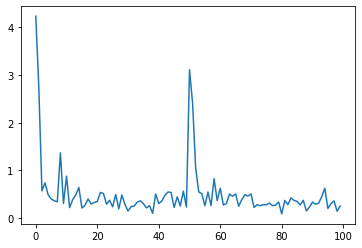

In [211]:
# plotting feature importance of embeddings
plt.plot(model.feature_importances_[:-1])

Нейросеть

12/12 [==============================] - 0s 1ms/step
MAE: 0.06488153264316589


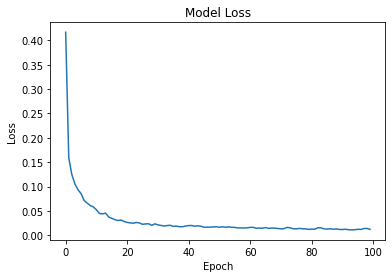

In [225]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(96, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mean_absolute_error')

history = model.fit(X_train, y_train, epochs=100, batch_size=16, verbose=0)

predictions = model.predict(X_test)

mae = mean_absolute_error(y_test, predictions)
print('MAE:', mae)

# Plotting the loss
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

ДОП

In [97]:
data

,word1,word2,label,emb_1_0,emb_1_1,emb_1_2,emb_1_3,emb_1_4,emb_1_5,emb_1_6,...,emb_2_291,emb_2_292,emb_2_293,emb_2_294,emb_2_295,emb_2_296,emb_2_297,emb_2_298,emb_2_299,lev_dist
0,аккордовый,квадрат,0,-0.012578,0.071381,-0.066920,0.132629,0.039623,0.068954,-0.102715,...,0.012084,0.054774,0.012667,-0.049291,0.144537,-0.074161,-0.035057,0.081322,0.129544,0
1,целый,цельный,1,-0.019124,0.034811,0.057754,0.119841,-0.034180,0.042868,0.015424,...,0.032209,0.014659,0.024586,-0.071244,-0.106860,0.002109,0.057067,-0.029967,0.069121,0
2,женский,господний,0,0.044881,-0.092671,0.050879,-0.044229,0.011045,0.028815,-0.058337,...,0.073815,0.014237,0.103689,0.109344,0.009336,0.047421,0.005184,0.071654,-0.028561,0
3,обличительный,динамизм,0,0.066741,0.038244,0.027620,0.058278,0.048305,0.110592,-0.115581,...,-0.102109,0.129003,-0.052745,-0.043174,-0.039006,0.050456,-0.007910,-0.029959,0.016620,0
4,сыскать,снискать,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3511,гнилой,гнилостный,1,0.022569,-0.047862,0.049707,0.058395,0.006504,0.046971,0.035626,...,-0.091607,0.088824,0.001456,-0.006952,0.041889,0.050071,0.102235,-0.003491,-0.002087,0
3512,кормильщица,притягательный,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
3513,абонемент,абонент,1,0.068919,0.042074,-0.030451,-0.087799,0.016597,-0.016370,0.019723,...,0.067424,0.100960,0.029388,-0.060928,0.016881,-0.025644,-0.061658,-0.017059,-0.043113,0
3514,беженец,выучить,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0


In [96]:
get_embedding(data['word1'][0])

array([-1.25777004e-02,  7.13808015e-02, -6.69195578e-02,  1.32629201e-01,
        3.96230109e-02,  6.89538270e-02, -1.02715276e-01, -2.07985435e-02,
       -4.17454605e-04, -6.66920096e-02,  1.85652584e-01, -1.44832075e-01,
        2.83512380e-02, -1.11901104e-01,  4.56056818e-02, -4.81510274e-02,
        8.36276039e-02, -9.19803232e-03,  9.81500838e-04,  5.74996658e-02,
       -2.92572589e-03,  6.52177706e-02, -4.75657806e-02,  4.61040102e-02,
       -3.82861830e-02,  5.70593216e-02, -3.37926932e-02,  1.21076353e-01,
       -1.81092322e-02,  9.62400343e-03, -1.48299234e-02,  1.01952113e-01,
        1.60059571e-01, -5.47798118e-03,  3.87733914e-02,  3.83970179e-02,
        1.25514701e-01, -8.64881873e-02,  2.29348727e-02, -2.13215649e-02,
       -1.91617105e-02, -1.42319629e-03, -1.11882702e-01, -8.07544217e-02,
       -5.52563854e-02,  1.29661132e-02, -3.10040861e-02, -4.55451086e-02,
        4.72736470e-02, -7.49781057e-02, -9.20100696e-03,  5.29071130e-02,
        6.45692181e-03,  

In [85]:
morph = pymorphy2.MorphAnalyzer()

word = 'знамя_NOUN'
parsed_word = morph.parse(word)[0]
pos = parsed_word.tag.POS

print(pos)

None


In [ ]:


# Создаем набор данных
X = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9], [10, 11, 12]])

# Создаем объект PCA и указываем, что хотим снизить размерность до 2
pca = PCA(n_components=2)

# Обучаем PCA на наборе данных
pca.fit(X)

# Применяем PCA для снижения размерности
X_transformed = pca.transform(X)

# Выводим преобразованный набор данных
print(X_transformed)